In [1]:
from sklearn.datasets import fetch_openml
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
%matplotlib inline

c:\Users\EonKim\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

X shape: (70000, 784)
y shape: (70000,)
Single sample shape: (28, 28)


<Figure size 432x288 with 0 Axes>

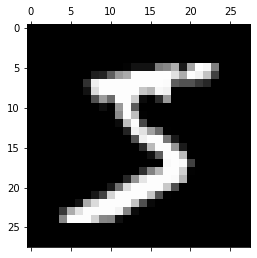

In [26]:
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

single_sample = X.loc[0,:].values.reshape(28,28)
print(f'Single sample shape: {single_sample.shape}')

plt.gray()
plt.matshow(single_sample)
plt.show()

In [27]:
train_samples = 60000
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])

X = X.iloc[permutation]
y = y.iloc[permutation]

X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size=train_samples, test_size=10000, random_state=0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


print(f'Training shape: {X_train.shape}')
print(f'Testing shape {X_test.shape}')

Training shape: (60000, 784)
Testing shape (10000, 784)


# Convolutional Layer 

$$ O = \frac{W - K + 2 \cdot P}{S} + 1 $$

In [37]:
class ConvolutionalLayer:
    def __init__(self, num_kernels, kernel_shape):
        self.num_kernels = num_kernels 
        self.kernel_shape = kernel_shape 
        self.k = self.kernel_shape[0]
        
        self.kernel_theta = torch.randn(self.num_kernels, self.kernel_shape[0], self.kernel_shape[1])
    
    def slider(self, image):
        h, w = image.shape
        for h_idx in range(h - (self.k - 1)): # h: height, w: width
            for w_idx in range(w - (self.k - 1)):
                single_slide_area = image[h_idx:(h_idx + self.k), w_idx:(w_idx + self.k)]
                yield single_slide_area, h_idx, w_idx 
    
    def forward(self, images):
        
        assert single_sample.dim() == 2
        
        _, w = images.shape 
        p = 0
        o = (w - self.k) + 1
        print('Padding shape: \t', p)
        print('Output shape: \t', o)
        
        output = torch.zeros((o, o, self.num_kernels))
        
        for single_slide_area, h_idx, w_idx in self.slider(images):
            if h_idx == 0 and w_idx == 0 :
                print('Region shape: \t', list(single_slide_area.shape))
                print('Kernel shape: \t', list(self.kernel_theta.shape))
                print('Single Slide: \t', list(output[h_idx, w_idx].shape))
            
            output[h_idx, w_idx] = torch.sum(single_slide_area * self.kernel_theta, axis=(1, 2))
        output = 1. / (1. + torch.exp(-output))
    
        return output

single_sample = X.loc[0].values.reshape(28, 28)
single_sample = torch.tensor(single_sample)

print('='*50)
print(f'Input shape: \t {list(single_sample.shape)}')
print('='*50)

Conv = ConvolutionalLayer(num_kernels=8, kernel_shape=(5, 5))
output = Conv.forward(single_sample)

print('='*50)
print(f'Conv (f) shape: \t {list(output.shape)}')
print('='*50)

Input shape: 	 [28, 28]
Padding shape: 	 0
Output shape: 	 24
Region shape: 	 [5, 5]
Kernel shape: 	 [8, 5, 5]
Single Slide: 	 [8]
Conv (f) shape: 	 [24, 24, 8]


In [41]:
class AffineSoftmaxLayer:
    def __init__(self, affine_weight_shape):
        self.affine_weight_shape = affine_weight_shape
        self.w = torch.zeros(self.affine_weight_shape[0] * self.affine_weight_shape[1] * self.affine_weight_shape[2], self.affine_weight_shape[3])
        self.b = torch.zeros(self.affine_weight_shape[3])
        
        
        print(f'Lecun initialization SD: {1/self.affine_weight_shape[3]}')
        self.w = torch.nn.init.normal_(self.w, mean=0, std=1/self.affine_weight_shape[3])
        self.b = torch.nn.init.normal_(self.b, mean=0, std=1/self.affine_weight_shape[3])
        
    def forward(self, image):
        image = image.reshape(1, -1)
        print(f'input shape: \t {image.shape}')
        print(f'weight shape: \t {self.w.shape}')
        print(f'bias shape \t {self.b.shape}')
        logits = torch.mm(image, self.w) + self.b 
        proba = torch.exp(logits) / torch.sum(torch.exp(logits))
        return proba 


print('='*50)
print(f'Input shape: \t {list(output.shape)}')
print('='*50)

# Forward: Affine and Softmax
affinesoftmax = AffineSoftmaxLayer(affine_weight_shape=(output.shape[0], output.shape[1], output.shape[2], len(np.unique(Y_train))))
output = affinesoftmax.forward(output)

print('='*50)
print(f'Affine & Soft(arg)max (f) shape: \t {list(output.shape)}')
print('='*50)

print(f'Probas: {pd.DataFrame(output.numpy()).to_string(index=False, header=False)}')

Input shape: 	 [24, 24, 8]
Lecun initialization SD: 0.1
input shape: 	 torch.Size([1, 4608])
weight shape: 	 torch.Size([4608, 10])
bias shape 	 torch.Size([10])
Affine & Soft(arg)max (f) shape: 	 [1, 10]
Probas: 0.112889 0.000923 0.000026 0.067042 0.000001 1.890935e-07 0.814461 0.001939 0.000121 0.002597
